In [1]:
import micromagneticmodel as mm
import discretisedfield as df
import oommfc as oc
import matplotlib.pyplot as plt
import numpy as np
import micromagneticdata as md
import matplotlib as mpl
import pandas as pd
%matplotlib inline

In [5]:
l=100e-9
w=100e-9
region=df.Region(p1=(-l,-w,0),p2=(l,w,1e-9))
cell=(2e-9,2e-9,1e-9)
mesh=df.Mesh(region=region,cell=cell)

In [11]:
Ms = 0.58e6
A = 15e-12
D = 3e-3
K = 0.8e6
def m_init(pos):
    x,y,z = pos
    if (x**2+y**2)**0.5 <= 20e-9:
        return (0,0,-1)
    else:
        return (0,0,1)
system = mm.System(name='M_location')
system.energy = mm.Exchange(A=A) + mm.UniaxialAnisotropy(K=K,u=(0,0,1))\
             +mm.Demag() + mm.DMI(D=D,crystalclass='Cnv_z')
system.dynamics = mm.Precession(gamma0=2.211e5)+mm.Damping(alpha=0.3)
system.m=df.Field(mesh=mesh,dim=3,value=m_init,norm=Ms)
Md = oc.MinDriver()
Md.drive(system)

Running OOMMF (ExeOOMMFRunner)[2022/12/05 10:25]... (11.6 s)


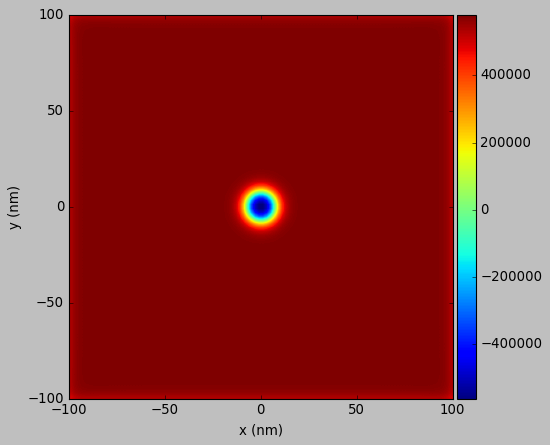

In [12]:
plt.style.use('classic')
system.m.z.plane(z=0).mpl.scalar()

In [13]:
td = oc.TimeDriver()
system.dynamics += mm.Slonczewski(J=25*(1e10),mp=(0,1,0),P=0.4,Lambda=1,eps_prime=0)
td.drive(system,t=1e-9,n=20)

Running OOMMF (ExeOOMMFRunner)[2022/12/05 10:25]... (89.6 s)


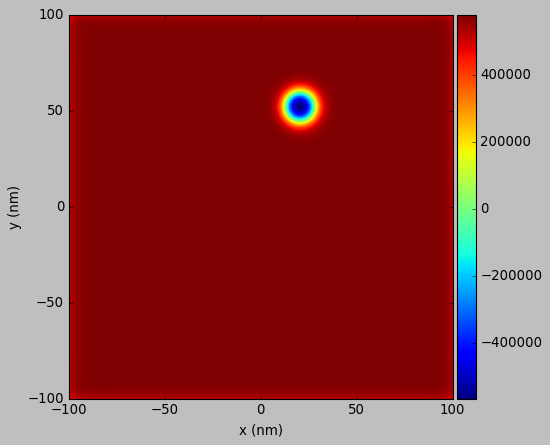

In [14]:
system.m.z.plane(z=0).mpl.scalar()

In [15]:
#积分的方式计算位置
data = md.Data(name='M_location')
N = -1
X = []
Y = []
for i in range(data[N].n):
    m = data[N][i].orientation.plane(z=0)
    q = m @ (m.derivative('x') & m.derivative('y'))
    Q = df.integral(q * df.dx * df.dy) / (4 * np.pi)
    x = df.Field(data[N][i].plane(z=0).mesh, dim =1, value = lambda pos:pos[0])
    y = df.Field(data[N][i].plane(z=0).mesh, dim =1, value = lambda pos:pos[1])
    Rx = df.integral(x * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
    Ry = df.integral(y * q * df.dx * df.dy) / df.integral(q * df.dx * df.dy)
    X.append(Rx*1e9)
    Y.append(Ry*1e9)

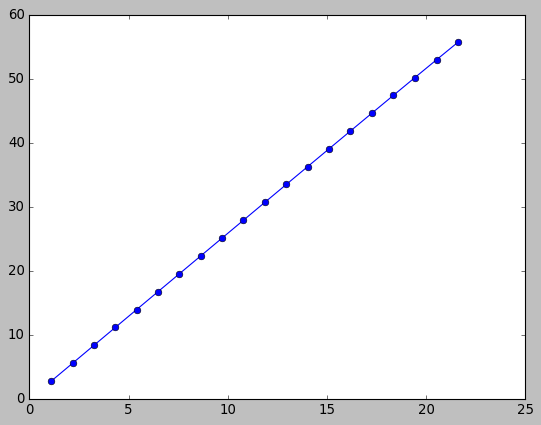

In [27]:
plt.plot(X,Y,'o-',c='b')
plt.show()

In [24]:
#修改后的位置
data = md.Data(name='M_location')
N = -1
X1 = []
Y1 = []
for i in range(data[N].n):
    m = data[N][i].orientation.plane(z=0)
    q = m @ (m.derivative('x') & m.derivative('y'))
    Q = np.sum(q.value[4:95,4:95,:,:]) * 4e-18 / (4 * np.pi)
    x = df.Field(data[N][i].plane(z=0).mesh, dim =1, value = lambda pos:pos[0])
    y = df.Field(data[N][i].plane(z=0).mesh, dim =1, value = lambda pos:pos[1])
    Qx = np.sum((q * x).value[4:95,4:95,:,:]) * 4e-18 / (4 * np.pi)
    Qy = np.sum((q * y).value[4:95,4:95,:,:]) * 4e-18 / (4 * np.pi)
    Rx = (Qx / Q)
    Ry = (Qy / Q)
    X1.append(Rx*1e9)
    Y1.append(Ry*1e9)

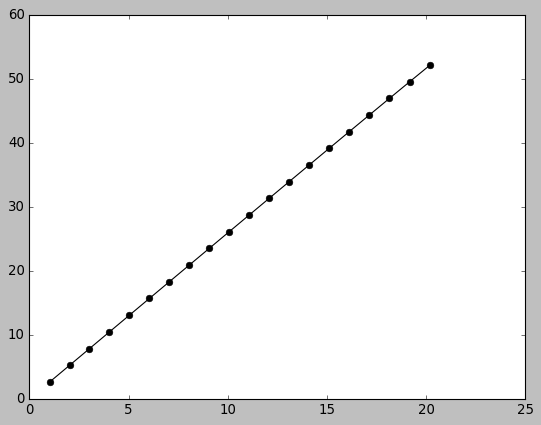

In [26]:
plt.plot(X1,Y1,'o-',c='k')
plt.show()

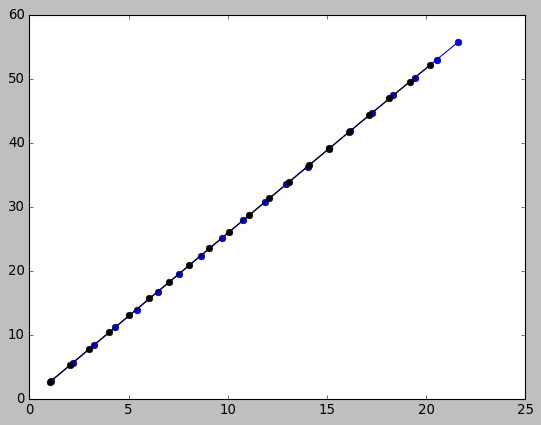

In [28]:
plt.plot(X,Y,'o-',c='b')
plt.plot(X1,Y1,'o-',c='k')
plt.show()

从磁矩图中可以大致发现，skyrmion最后所在位置的纵坐标刚刚超过50，显然我们修改过后的计算方法是准确的。这是由于赛道边缘磁矩也是倾斜的，对q进行平面积分时，也把边缘算进去了。事实上，当赛道宽度变窄时，这个影响更大。然而，当论文中需要讨论skyrmion在边缘时的受力时，由于它可能离边缘很近，就需要重新设置这些值：[4:95,4:95,:,:]。